### Parámetros comunes

In [1]:
datasets = {"restaurants":["gijon", "barcelona", "madrid", "paris", "newyorkcity"],
            "pois":["barcelona", "madrid", "paris", "newyorkcity", "london"],
            "amazon":["fashion", "digital_music"]}

models = ["ATT2ITM", "BOW2ITM", "USEM2ITM"]

### Evaluar nuestros modelos solo en los casos de cold-start

In [ ]:
from src.experiments.Common import load_best_model
import pandas as pd

cold_start_res = []

for dataset, subsets in datasets.items():
    for subset in subsets:
        for model in models:
            # Cargar el modelo con mejores hiperparámetros
            model_class = load_best_model(model=model, dataset=dataset, subset=subset)
            model_class.train(dev=True, save_model=True) # Cargar el modelo
            # Eliminar usuarios que aparecen en TRAIN
            train_dev_users = model_class.DATASET.DATA["TRAIN_DEV"].userId.unique()
            model_class.DATASET.DATA["TEST"] = model_class.DATASET.DATA["TEST"][~model_class.DATASET.DATA["TEST"]["userId"].isin(train_dev_users)]
            model_class.DATASET.DATA["TEST"] = model_class.DATASET.DATA["TEST"].drop_duplicates(subset=["userId", "id_item"], keep='last', inplace=False)
            # Evaluar en el conjunto de test
            test_ret = model_class.evaluate(test=True)
            cold_start_res.append([dataset, subset, model]+test_ret.values.tolist()[0][1:])

cold_start_res = pd.DataFrame(cold_start_res, columns=["dataset", "subset", "model"] + test_ret.columns.tolist()[1:])

In [5]:
cold_start_res.to_excel("cold_start_evaluation.xlsx")

### Gráficas de evolución de nuestros modelos y baselines en función del usuarios en Train
No parece verse mejora clara en los baselines, por tanto no se mostrarán gráficas.

ValueError: 

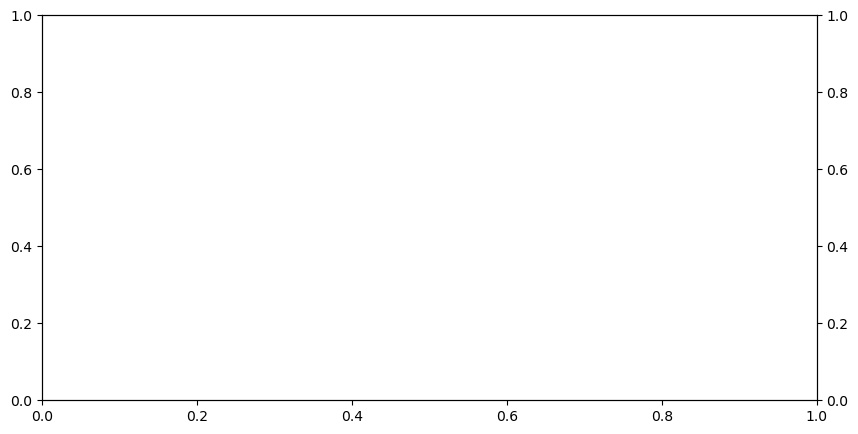

In [6]:
# Importar pandas
import matplotlib.pyplot as plt
import pandas as pd
import os

top = 5
cumulate = True

datasets = {"restaurants":["gijon", "barcelona", "madrid", "paris", "newyorkcity"],
            "pois":["barcelona", "madrid", "paris", "newyorkcity", "london"],
            "amazon":["fashion", "digital_music"]}

datasets = {"restaurants":["barcelona"]}

models = ["ATT2ITM", "BOW2ITM", "USEM2ITM"]

best_model = pd.read_csv("models/best_models.csv")

for dataset, subsets in datasets.items():
    for subset in subsets:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax2 = ax.twinx()
        subset_results = pd.DataFrame(range(top+1), columns=["train_dev_items"])
        
        baseline_path = f"models/Baselines/{dataset}/{subset}/user_results.csv"
        if os.path.exists(baseline_path): 
            baselines = pd.read_csv(baseline_path).rename(columns={"cold":"train_dev_items"})
            baselines_names = baselines.columns.to_list(); baselines_names.remove("userId"); baselines_names.remove("train_dev_items")
            baselines = baselines.groupby("train_dev_items")[baselines_names].mean().reset_index()
            subset_results = subset_results.merge(baselines, how="left")

            for bl in baselines_names: # ["GridSearch_BPR", "GridSearch_EASEᴿ", "MostPop"]: 
                if cumulate: subset_results[bl] = subset_results[bl].expanding().mean()
                ax.plot(subset_results["train_dev_items"], subset_results[bl], "--", label=bl)

        else: raise ValueError

        for model in models:
            md5 = best_model.loc[(best_model.dataset == dataset) & (best_model.subset == subset) & (best_model.model == model)]["model_md5"].values[0]
            results_path = f"models/{model}/{dataset}/{subset}/{md5}/final_user_eval.csv"
            if os.path.exists(results_path):
                results = pd.read_csv(results_path)
                results = results.groupby("cold").agg(mn=("NDCG", "mean"), n_samples=("NDCG", "count")).reset_index().rename(columns={"cold":"train_dev_items", "mn":model})
                if cumulate: results[model] = results[model].expanding().mean()
                subset_results = subset_results.merge(results, how="left")
                ax.plot(subset_results["train_dev_items"], subset_results[model], "-", label=model)
            else:
                raise ValueError
        
        subset_results["n_samples"] = subset_results["n_samples"].fillna(0)

        ax2.plot(subset_results["train_dev_items"], subset_results["n_samples"], ":",label="")

        ax.set_ylim([0, 1])
        ax2.set_ylim([0, subset_results["n_samples"].max()])
        ax.set_ylabel('AVG NDCG')
        plt.title(f"{dataset.title()} - {subset.title()}")
        ax.set_xlabel("Number of reviews in Train set")
        # ax.set_xticks(range(top+1))
        # ax.set_xlim([0, top])
        ax2.set_ylabel('Number of Test cases')

        ax.legend()
        plt.show()